## Лабораторная работа 2: Использование численных методов в задачах оптимизации
_Команда 4_ <br>
_Баширов Роман, Крылов Виктор, Моннар Иван, Капускина Анна_
### 1. Поиск минимума функции:

\begin{align}
f(x)= \frac {1}{2} [ (x_ {1})^ {2} + \sum _ {i=1}^ {2} (x_ {i}-x_ {i+1})^ {2} + (x_ {3})^ {2} ]- x_ {1}
\end{align}


##### Представление применимости алгоритмов BFGS и L-BFGS к данной оптимизационной задаче

$\frac{df}{dx_1} = 2x_1-x_2-1 = f_{x_1}$, $\frac{df}{dx_2} = 2x_2-x_1-x_3 = f_{x_2}$, $\frac{df}{dx_3} = 2x_3-x2 = f_{x_3}$

Первые частные производные непрерывны.

$\frac{{d^2f}}{{dx_1^2}} = 2$, $\frac{{d^2f}}{{dx_1 dx_2}} = -1$, $\frac{{d^2f}}{{dx_1 dx_3}} = 0$

$\frac{{d^2f}}{{dx_2 dx_1}} = -1$, $\frac{{d^2f}}{{dx^2_2}} = 2$, $\frac{{d^2f}}{{dx_2 dx_3}} = -1$

$\frac{{d^2f}}{{dx_3 dx_1}} = 0$, $\frac{{d^2f}}{{dx_3 dx_2}} = -1$, $\frac{{d^2f}}{{dx_3^2}} = 2$

Вторые частные производные также непрервны, следовательно функция дважды дифференцируема:

$$ Hessian = 
\begin{bmatrix}
    {2}       & {-1} & {0} &  \\
    {-1}       & {2} & {-1} &  \\
    {0}       & {-1} & {2} & 
\end{bmatrix} $$

In [1]:
import numpy as np

Hessian = np.array([[2, -1, 0],
                    [-1, 2, -1],
                    [0, -1, 2]])

eigenvalues = np.linalg.eigvals(Hessian)

print("Собственные значения матрицы Hessian:")
print(eigenvalues)

Собственные значения матрицы Hessian:
[3.41421356 2.         0.58578644]


Так как собственные значения положительные, значит функция имеет локальный минимум в данной точке, следовательно, она выпуклая.

##### *Небольшая подготовка*

In [2]:
import scipy.optimize as opt

# Objective function
def f(x):
    return 0.5 * ((x[0])**2 + (x[0] - x[1])**2 + (x[1] - x[2])**2 + (x[2])**2) - x[0]


# Derivative
def f1(x):
    return np.array([2 * x[0] - x[1] - 1, -x[0] + 2 * x[1] - x[2], - x[1] + 2 * x[2]])

def f2(x, func=f, epsilon=10e-5):
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x_plus_epsilon = x.copy()
        x_minus_epsilon = x.copy()
        x_plus_epsilon[i] += epsilon
        x_minus_epsilon[i] -= epsilon
        grad[i] = (func(x_plus_epsilon) - func(x_minus_epsilon)) / (2 * epsilon)
    return grad


def linear_search(f, fprime, x, p):
    
    alpha = 1.0
    c = 1e-4  
    rho = 0.9  

    while f(x + alpha * p) > f(x) + c * alpha * np.dot(fprime(x), p):
        alpha *= rho

    return alpha

##### Реализация алгоритма BFGS

In [3]:
def bfgs_method(f, fprime, x0, maxiter=None, epsi=10e-3):
    """
    Алгоритм BFGS

    Параметры:
    - f: функция, которую нужно минимизировать
    - fprime: градиент функции func
    - x0: начальное приближение
    - max_iter: максимальное количество итераций
    - epsi: необходимая точность
    """
    if maxiter is None:
        maxiter = len(x0) * 100

    count = 0
    gfk = fprime(x0)
    N = len(x0)
    I = np.eye(N, dtype=int)
    Hk = I
    xk = x0

    while np.linalg.norm(gfk) > epsi and count < maxiter:

        pk = -np.dot(Hk, gfk)
        alpha_k = linear_search(f, fprime, xk, pk)

        xkp1 = xk + alpha_k * pk
        sk = xkp1 - xk
        xk = xkp1

        gfkp1 = fprime(xkp1)
        yk = gfkp1 - gfk
        gfk = gfkp1

        ro = 1.0 / (np.dot(yk, sk))
        A1 = I - ro * sk[:, np.newaxis] * yk[np.newaxis, :]
        A2 = I - ro * yk[:, np.newaxis] * sk[np.newaxis, :]
        Hk = np.dot(A1, np.dot(Hk, A2)) + (ro * sk[:, np.newaxis] *
                                           sk[np.newaxis, :])
        count += 1

    return xk, count

##### Реализация алгоритма L-BFGS

In [4]:
def lbfgs_method(f, fprime, x0, maxiter=100, epsi=1e-5, m=10):
    n = len(x0)
    x = x0.copy()
    I = np.eye(n)
    Hk = I

    for k in range(maxiter):
        gk = fprime(x)
        if np.linalg.norm(gk) < epsi:
            break
        
        pk = -np.dot(Hk, gk)
        alpha = linear_search(f, fprime, x, pk)
        x_next = x + alpha * pk
        sk = x_next - x
        yk = fprime(x_next) - gk
        
        if np.dot(yk, sk) > 0:
            rhok = 1.0 / np.dot(yk, sk)
            A1 = I - np.outer(sk, yk) * rhok
            A2 = I - np.outer(yk, sk) * rhok
            Hk = np.dot(A1, np.dot(Hk, A2)) + np.outer(sk, sk) * rhok
        
        x = x_next
    
    return x, k

##### Приближение матрицы Гессе

Матрица Гессе может быть вычислена с помощью разностной аппроксимации производных.

$$\frac{\partial^2 f}{\partial x_i\,\partial x_j} = 
\frac{ f(x + (e_i + e_j) h) - f(x + e_i h) - f(x + e_j h) + f(x) } {h^2}$$

где $x$  - вектор переменных, а $e_i$ и $e_j$ - единичные вектора. Эта формула требует вычисления значений функции  $f$  в  $\frac {n (n + 1)} {2}$  точках. Погрешность формулы имеет порядок $O(h)$.

In [5]:
def hessian(f, x, epsi=10e-4):
    n = len(x)
    hessian = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            e_i = np.zeros(n)
            e_i[i] = 1
            e_j = np.zeros(n)
            e_j[j] = 1
            hessian[i,j] = (f(x + (e_i + e_j) * epsi) - f(x + e_i * epsi) - f(x + e_j * epsi) + f(x)) / (epsi * epsi)
    return hessian

In [6]:
np.round(hessian(f, np.array([999., 999., 999.])))

array([[ 2., -1.,  0.],
       [-1.,  2., -1.],
       [ 0., -1.,  2.]])

##### Сравнение алгоритмов BFGS и L-BFGS

In [7]:
import timeit


def func_to_measure():
    bfgs_method(f, f1, np.array([999., 999., 999.]), epsi=10e-6)
    pass
execution_time = timeit.timeit(func_to_measure, number=1000)
print(f"Время выполнения BFGS аналитическим методом: {execution_time:.2f} секунд")
result, k = bfgs_method(f, f1, np.array([999., 999., 999.]), epsi=10e-6)

print('Result of BFGS method:')
print(f'Final Result (best point): {result}')
print(f'Iteration Count: {k}')
print('------------------------------------')


def func_to_measure():
    bfgs_method(f, f2, np.array([999., 999., 999.]), epsi=10e-6)
    pass
execution_time = timeit.timeit(func_to_measure, number=1000)
print(f"Время выполнения BFGS численным методом: {execution_time:.2f} секунд")
result, k = bfgs_method(f, f2, np.array([999., 999., 999.]), epsi=10e-6)

print('Result of BFGS method:')
print(f'Final Result (best point): {result}')
print(f'Iteration Count: {k}')
print('------------------------------------')


def func_to_measure():
    lbfgs_method(f, f1, np.array([999., 999., 999.]), epsi=10e-6)
    pass
execution_time = timeit.timeit(func_to_measure, number=1000)
print(f"Время выполнения L-BFGS аналитическим методом: {execution_time:.2f} секунд")
result, k = lbfgs_method(f, f1, np.array([999., 999., 999.]), epsi=10e-6)
print('Result of L-BFGS method:')
print(f'Final Result (best point): {result}')
print(f'Iteration Count: {k}')
print('------------------------------------')


def func_to_measure():
    lbfgs_method(f, f2, np.array([999., 999., 999.]), epsi=10e-6)
    pass
execution_time = timeit.timeit(func_to_measure, number=1000)
print(f"Время выполнения L-BFGS численным методом: {execution_time:.2f} секунд")
result, k = lbfgs_method(f, f2, np.array([999., 999., 999.]), epsi=10e-6)
print('Result of L-BFGS method:')
print(f'Final Result (best point): {result}')
print(f'Iteration Count: {k}')
print('------------------------------------')


def func_to_measure():
    result = opt.minimize(f, [999., 999., 999.], method='BFGS', tol=10e-6)
    pass
execution_time = timeit.timeit(func_to_measure, number=1000)
result = opt.minimize(f, [999., 999., 999.], method='BFGS', tol=10e-6)
optimal_solution = result.x
print(f"Время выполнения BFGS с помощью scipy.optimize: {execution_time:.2f} секунд")
print('Result of BFGS method:')
print(f'Final Result (best point): {result.x}')
print(f'Iteration Count: {result.nit}')
print('------------------------------------')


def func_to_measure():
    result = opt.minimize(f, [999., 999., 999.], method='L-BFGS-B', tol=10e-6)
    pass
execution_time = timeit.timeit(func_to_measure, number=1000)
result = opt.minimize(f, [999., 999., 999.], method='L-BFGS-B', tol=10e-6)
print(f"Время выполнения L-BFGS с помощью scipy.optimize: {execution_time:.2f} секунд")
print('Result of L-BFGS method:')
print(f'Final Result (best point): {result.x}')
print(f'Iteration Count: {result.nit}')

Время выполнения BFGS аналитическим методом: 0.25 секунд
Result of BFGS method:
Final Result (best point): [0.75 0.5  0.25]
Iteration Count: 4
------------------------------------
Время выполнения BFGS численным методом: 0.51 секунд
Result of BFGS method:
Final Result (best point): [0.75 0.5  0.25]
Iteration Count: 4
------------------------------------
Время выполнения L-BFGS аналитическим методом: 0.27 секунд
Result of L-BFGS method:
Final Result (best point): [0.75 0.5  0.25]
Iteration Count: 4
------------------------------------
Время выполнения L-BFGS численным методом: 0.61 секунд
Result of L-BFGS method:
Final Result (best point): [0.75 0.5  0.25]
Iteration Count: 4
------------------------------------
Время выполнения BFGS с помощью scipy.optimize: 2.61 секунд
Result of BFGS method:
Final Result (best point): [0.74999941 0.49999928 0.2499994 ]
Iteration Count: 6
------------------------------------
Время выполнения L-BFGS с помощью scipy.optimize: 1.98 секунд
Result of L-BFGS 

### 2. Практическое применение: использование метода оптимизации L-BFGS для решения задачи логистической регрессии

##### Представление набора данных

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
card_df = pd.read_csv('creditcard.csv')

In [10]:
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Text(0.5, 1.0, 'Class Distributions (0: No Fraud || 1: Fraud)')

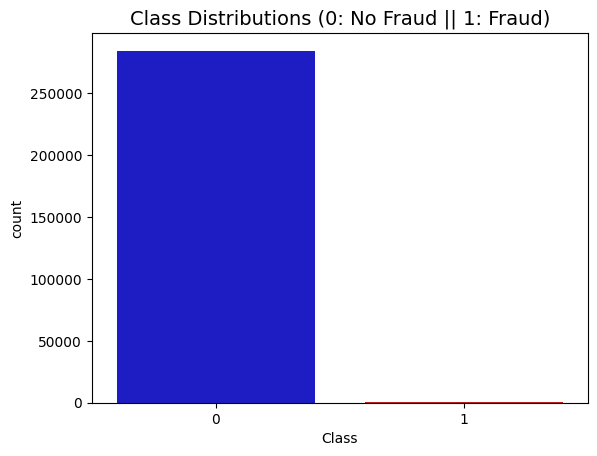

In [11]:
colors = ["#0101DF", "#DF0101"]

sns.countplot(x=card_df['Class'], palette=colors)
plt.title('Class Distributions (0: No Fraud || 1: Fraud)', fontsize=14)

In [12]:
df = card_df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

new_df = normal_distributed_df.sample(frac=1, random_state=42)

In [13]:
new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
60084,49149.0,-0.261447,0.464762,2.613925,0.673922,-0.333083,-0.075094,0.339977,-0.229996,0.883535,...,-0.094293,0.147253,-0.218888,0.356560,-0.129533,-0.514620,-0.369864,-0.407652,0.01,0
262560,160537.0,0.567539,3.309385,-6.631268,6.394574,-0.054172,-2.396535,-2.792489,0.514811,-3.541780,...,0.614221,-0.365047,-0.180409,-0.523271,0.645054,0.246466,0.902675,0.473571,4.69,1
123355,76893.0,1.227801,1.195754,-1.718185,1.459516,0.999469,-1.331441,0.622989,-0.182056,-0.586860,...,-0.187989,-0.506460,-0.254365,-0.344754,0.850268,-0.288875,0.031530,0.082036,1.00,0
118308,75033.0,-0.430330,0.985633,0.645789,0.317131,0.616332,-1.347462,1.078234,-0.161518,-0.492856,...,-0.016378,-0.207609,-0.164119,0.255280,0.454798,-0.505032,-0.039456,-0.006358,30.14,1
233258,147501.0,-1.611877,-0.408410,-3.829762,6.249462,-3.360922,1.147964,1.858425,0.474858,-3.838399,...,1.245582,0.616383,2.251439,-0.066096,0.538710,0.541325,-0.136243,-0.009852,996.27,1


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

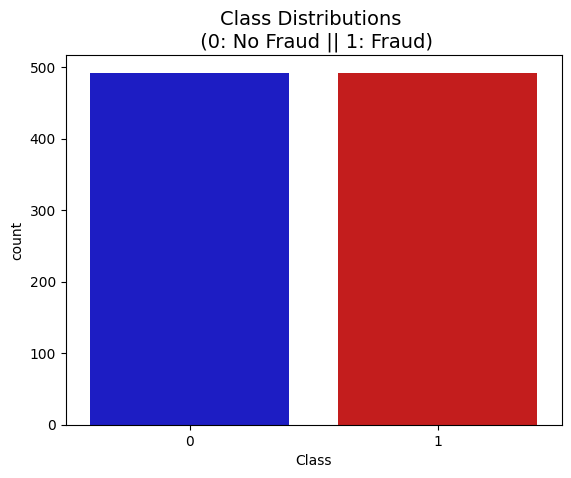

In [14]:
sns.countplot(x=new_df['Class'], palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

##### Реализация логистической регрессии

In [15]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

X = new_df.drop('Class', axis=1)
y = new_df['Class']

# Стандартизация признаков
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Разделение данных на тренировочные и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение функции потерь и градиента для логистической регрессии
def logistic_loss(w):
    z = np.dot(X_train, w)
    return -np.sum(y_train * np.log(1 / (1 + np.exp(-z))) + (1 - y_train) * np.log(1 - 1 / (1 + np.exp(-z))))

def logistic_gradient(w):
    z = np.dot(X_train, w)
    p = 1 / (1 + np.exp(-z))
    return -np.dot(X_train.T, y_train - p)

def func(w, X, y):
    l2_coeff = 1
    matr = X.dot(w) * -y
    matr = np.logaddexp(0, matr)
    return 1 / X.shape[0] * np.sum(matr) + l2_coeff * np.dot(w[1:], w[1:])

# Начальное значение весов
x0 = np.zeros(X_train.shape[1])

# Вызов L-BFGS метода для обучения логистической регрессии на тренировочных данных
optimal_weights, iterations = lbfgs_method(logistic_loss, logistic_gradient, x0)

# Оценка производительности модели на тестовых данных
def predict(X, weights):
    z = np.dot(X, weights)
    return 1 / (1 + np.exp(-z))

y_pred = predict(X_test, optimal_weights)
y_pred_binary = (y_pred >= 0.9).astype(int)


# Оценка точности
accuracy = np.mean(y_pred_binary == y_test)

# Вывод результатов
print("Оптимальные веса:\n", optimal_weights)
print("Количество итераций:", iterations)
print("Точность на тестовых данных:", accuracy)

Оптимальные веса:
 [-0.28569739 -4.81494973 -1.35095262 -3.7554876   8.55382408 -0.14455042
  0.07327985 13.55724837 -3.42455066  4.58004524 -8.33431873  0.50855861
  5.37605004 -0.61410579  0.80893726  0.56426051 -5.23436681 -6.17035309
  4.65708674 -1.39724363  0.29441326 -0.44861099 -1.05262389 -0.73210332
 -0.17025912 -0.49885798  0.79547822  0.28690979  0.38974242 -2.62475274]
Количество итераций: 60
Точность на тестовых данных: 0.868020304568528


##### Сравнение характеристики работы алгоритмов

In [16]:
def func_to_measure():
    optimal_weights, iterations = bfgs_method(logistic_loss, logistic_gradient, x0)
    pass
execution_time = timeit.timeit(func_to_measure, number=1)
print(f"Время выполнения BFGS: {execution_time:.2f} секунд")
optimal_weights, iterations = bfgs_method(logistic_loss, logistic_gradient, x0)
print(f'Final Result:\n{optimal_weights}')
print(f'Iteration Count: {iterations}')
print('------------------------------------')

def func_to_measure():
    optimal_weights, iterations = lbfgs_method(logistic_loss, logistic_gradient, x0)
    pass
execution_time = timeit.timeit(func_to_measure, number=1)
print(f"Время выполнения L-BFGS: {execution_time:.2f} секунд")
optimal_weights, iterations = lbfgs_method(logistic_loss, logistic_gradient, x0)
print(f'Final Result:\n{optimal_weights}')
print(f'Iteration Count: {iterations}')
print('------------------------------------')

def func_to_measure():
    weights = result_scipy = opt.minimize(func, x0, method='L-BFGS-B', args=(X_train, y_train))
    pass
execution_time = timeit.timeit(func_to_measure, number=1)
print(f"Время выполнения opt.minimize: {execution_time:.2f} секунд")
weights = result_scipy = opt.minimize(func, x0, method='L-BFGS-B', args=(X_train, y_train))
print(f'Final Result:\n{optimal_weights}')
print(f'Iteration Count: {iterations}')

Время выполнения BFGS: 1.12 секунд
Final Result:
[-0.28573811 -4.8148279  -1.35108086 -3.75542179  8.55376477 -0.14421934
  0.07335402 13.55657009 -3.42419362  4.57991893 -8.33427785  0.5087581
  5.37610219 -0.61410749  0.80899294  0.56419624 -5.23429357 -6.17035348
  4.65724475 -1.3972359   0.29432039 -0.44857279 -1.05245232 -0.73212788
 -0.17017229 -0.49876499  0.79556182  0.28686732  0.38977998 -2.62468672]
Iteration Count: 52
------------------------------------
Время выполнения L-BFGS: 1.17 секунд
Final Result:
[-0.28569739 -4.81494973 -1.35095262 -3.7554876   8.55382408 -0.14455042
  0.07327985 13.55724837 -3.42455066  4.58004524 -8.33431873  0.50855861
  5.37605004 -0.61410579  0.80893726  0.56426051 -5.23436681 -6.17035309
  4.65708674 -1.39724363  0.29441326 -0.44861099 -1.05262389 -0.73210332
 -0.17025912 -0.49885798  0.79547822  0.28690979  0.38974242 -2.62475274]
Iteration Count: 60
------------------------------------
Время выполнения opt.minimize: 0.35 секунд
Final Result

По результатам сравнения видно, что собственные реализации BFGS и L-BFGS уступают в скорости при поиске оптимальных весов, хотя при поиске минимума функции отработали в ~10 раз быстрее.

Если сравнивать между собой BFGS и L-BFGS, то второй вариант работает немного дольше, так как необходимо провести дополнительные изменения в истории, но при этом требует меньше памяти. BFGS же за меньшее число итераций находит минимум функции.

Также обе реализации дали такой же результат, что и SciPy.